<a href="https://colab.research.google.com/github/AmiteshMagar/Fake-News-prediction-using-GloVe-Embeddings/blob/main/Fake_news_classification_using_GloVe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Classifiying fake news using CNN and GloVe embeddings to achieve maximum accuracy

In [1]:
#import libraries
import numpy as np
import pandas as pd
import re
import string
import unicodedata
import html

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import nltk
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize

nltk.download('popular')

from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from bs4 import BeautifulSoup

from string import punctuation

import keras
from keras.preprocessing import text, sequence
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## importing the dataset

In [3]:
fake = pd.read_csv('/content/drive/MyDrive/Datasets/Fake news dataset/Fake.csv')
real = pd.read_csv('/content/drive/MyDrive/Datasets/Fake news dataset/True.csv')

In [4]:
fake['Cat'] = 0
real['Cat'] = 1

In [5]:
real.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  Cat  
0  December 31, 2017     1  
1  December 29, 2017     1  
2  December 31, 2017     1  
3  December 30, 2017     1  
4  December 29, 2017     1

In [6]:
fake.head()

title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  Cat  
0  December 31, 2017    0  
1  December 31, 2017    0  
2  December 30, 2017    0  
3  December 29, 2017    0  
4  December 25, 2017    0

In [7]:
df = pd.concat([real, fake])
df.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  Cat  
0  December 31, 2017     1  
1  December 29, 2017     1  
2  December 31, 2017     1  
3  December 30, 2017     1  
4  December 29, 2017     1

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


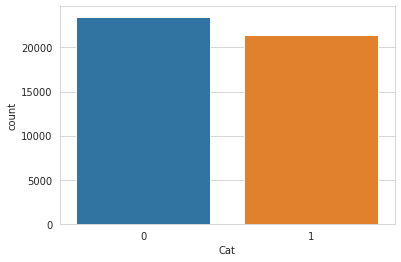

In [8]:
sns.set_style('whitegrid')
sns.countplot(df.Cat)

In [9]:
df.isna().sum()

title      0
text       0
subject    0
date       0
Cat        0
dtype: int64

In [10]:
df.subject.value_counts()

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

In [11]:
df['text'] = df['text'] + df['title']
del df['title']
del df['subject']
del df['date']

In [12]:
df.head()

text  Cat
0  WASHINGTON (Reuters) - The head of a conservat...    1
1  WASHINGTON (Reuters) - Transgender people will...    1
2  WASHINGTON (Reuters) - The special counsel inv...    1
3  WASHINGTON (Reuters) - Trump campaign adviser ...    1
4  SEATTLE/WASHINGTON (Reuters) - President Donal...    1

In [13]:
#removing stopwords
stop = set(stopwords.words('english'))
puncuation = list(string.punctuation)
stop.update(punctuation)

## Cleaning the data

In [14]:
# A different way to clean text, gives inaccuracy later

# def remove_special_chars(text):
#     re1 = re.compile(r'  +')
#     x1 = text.lower().replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
#         'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
#         '<br />', "\n").replace('\\"', '"').replace('<unk>', 'u_n').replace(' @.@ ', '.').replace(
#         ' @-@ ', '-').replace('\\', ' \\ ')
#     return re1.sub(' ', html.unescape(x1))

# # def remove_contractions(sent):
# #     # creating an empty list
# #     expanded_words = []   
# #     for word in sent.split(" "):
# #       # using contractions.fix to expand the shortened words
# #         expanded_words.append(contractions.fix(word)) 

# #     return ' '.join(expanded_words)

# def to_lowercase(text):
#     return text.lower()



# def remove_punctuation(text):
#     """Remove punctuation from list of tokenized words"""
#     translator = str.maketrans('', '', string.punctuation)
#     return text.translate(translator)


# def replace_numbers(text):
#     """Replace all interger occurrences in list of tokenized words with textual representation"""
#     return re.sub(r'\d+', '', text)


# def remove_whitespaces(text):
#     return text.strip()


# # def remove_stopwords(words, stop_words):
# #     """
# #     :param words:
# #     :type words:
# #     :param stop_words: from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
# #     or
# #     from spacy.lang.en.stop_words import STOP_WORDS
# #     :type stop_words:
# #     :return:
# #     :rtype:
# #     """
# #     return [word for word in words if word not in stop_words]


# def stem_words(words):
#     """Stem words in text"""
#     stemmer = PorterStemmer()
#     return [stemmer.stem(word) for word in words]

# def lemmatize_words(words):
#     """Lemmatize words in text"""

#     lemmatizer = WordNetLemmatizer()
#     return [lemmatizer.lemmatize(word) for word in words]

# def lemmatize_verbs(words):
#     """Lemmatize verbs in text"""

#     lemmatizer = WordNetLemmatizer()
#     return ' '.join([lemmatizer.lemmatize(word, pos='v') for word in words])

# def text2words(text):
#     return word_tokenize(text)

# def clean_text( text):
#     # text = remove_contractions(text)
#     text = remove_special_chars(text)
#     text = remove_punctuation(text)
#     text = to_lowercase(text)
#     text = replace_numbers(text)
#     words = text2words(text)
#     # words = remove_stopwords(words, stop_words)
#     #words = stem_words(words)# Either stem ovocar lemmatize
#     words = lemmatize_words(words)
#     words = lemmatize_verbs(words)

#     return ''.join(words)

In [15]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text



In [16]:
df['text'] = df['text'].apply(denoise_text)

/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning: "https://100percentfedup.com/video-hillary-asked-about-trump-i-just-want-to-eat-some-pie/https://100percentfedup.com/video-hillary-asked-about-trump-i-just-want-to-eat-some-pie/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning: "https://fedup.wpengine.com/wp-content/uploads/2015/04/hillarystreetart.jpghttps://fedup.wpengine.com/wp-content/uploads/2015/04/hillarystreetart.jpg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/usr/local/lib/python3.7/dist-packages/b

In [17]:
df.head()

text  Cat
0  WASHINGTON (Reuters) head conservative Republi...    1
1  WASHINGTON (Reuters) Transgender people allowe...    1
2  WASHINGTON (Reuters) special counsel investiga...    1
3  WASHINGTON (Reuters) Trump campaign adviser Ge...    1
4  SEATTLE/WASHINGTON (Reuters) President Donald ...    1

In [18]:
df.sample(1)['text'].values[0]

"know, many times conservatives declared Hillary Clinton email scandal end political career thing land prison, think would something concrete could use her. Unfortunately, anything yet. Zip. Zilch. Nada. thing points anything criminal least.On Saturday, Clinton voluntarily met FBI could stop wasting time investigation former First Lady use private email server move actual crimes. Secretary Clinton gave voluntary interview morning email arrangements secretary, Clinton spokesman Nick Merrill following meeting. pleased opportunity assist Department Justice bringing review conclusion. Saturday evening, CNN Senior Producer, Edward Mejia Davis, dropped inside info Twitter namely, soon official announcement Clinton charged crime, largely obvious beginning (to anyone figure intricacies operating salad fork, anyway) committed one.Sources tell CNN's Evan Perez: expectation announcement charges Clinton email probe w/in next two weeks Edward Mejia Davis (@TeddyDavisCNN) July 2, 2016In evening inte

## WordCloud for Real text

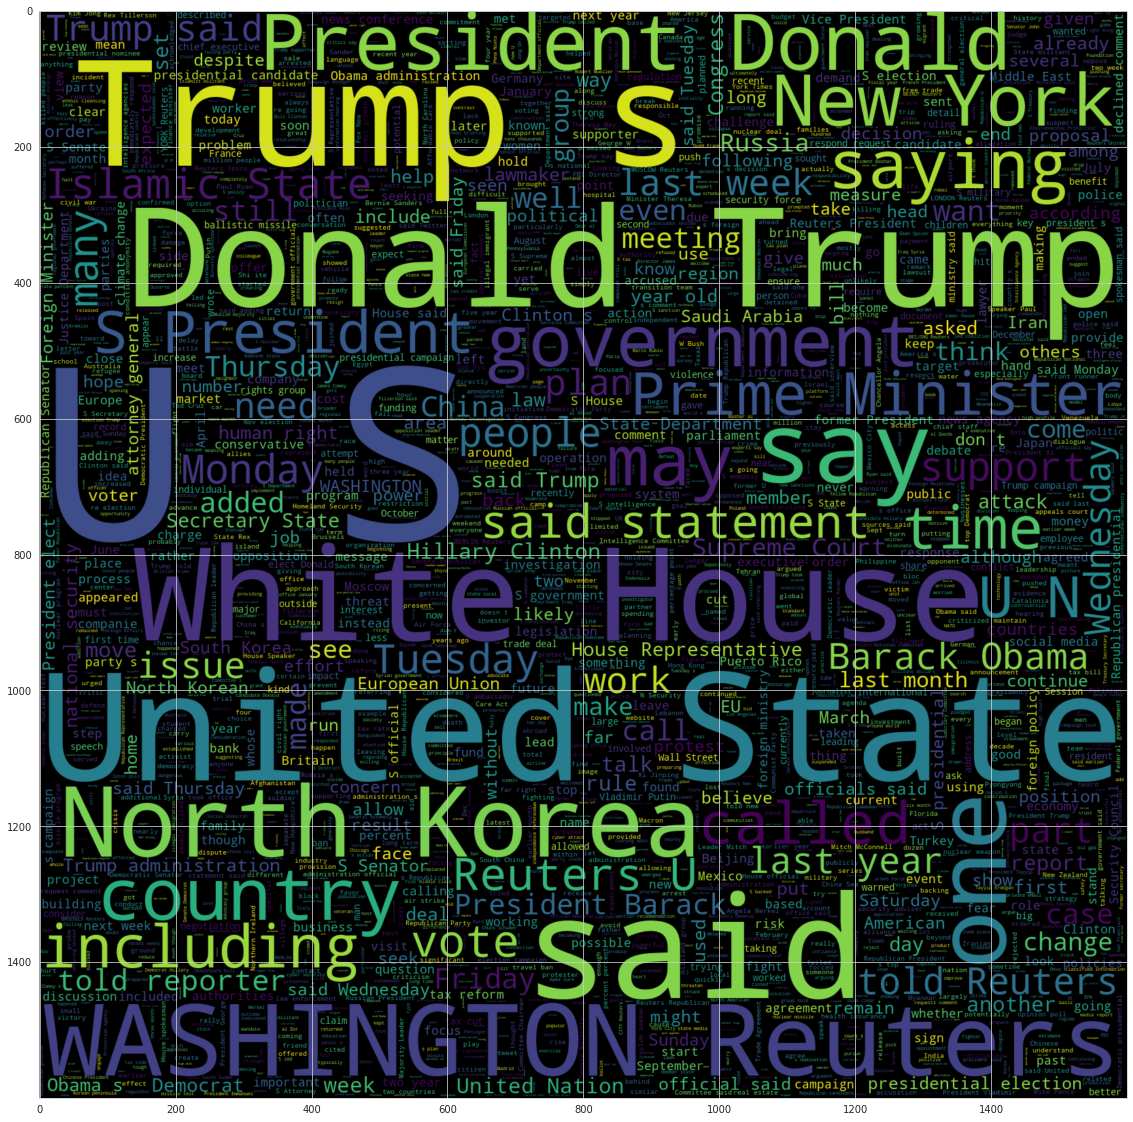

In [19]:
plt.figure(figsize = (20,20)) 
# Text that is not Fake
wc = WordCloud(max_words = 2500 , width = 1600 , height = 1600 , stopwords = STOPWORDS).generate(" ".join(df[df.Cat == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

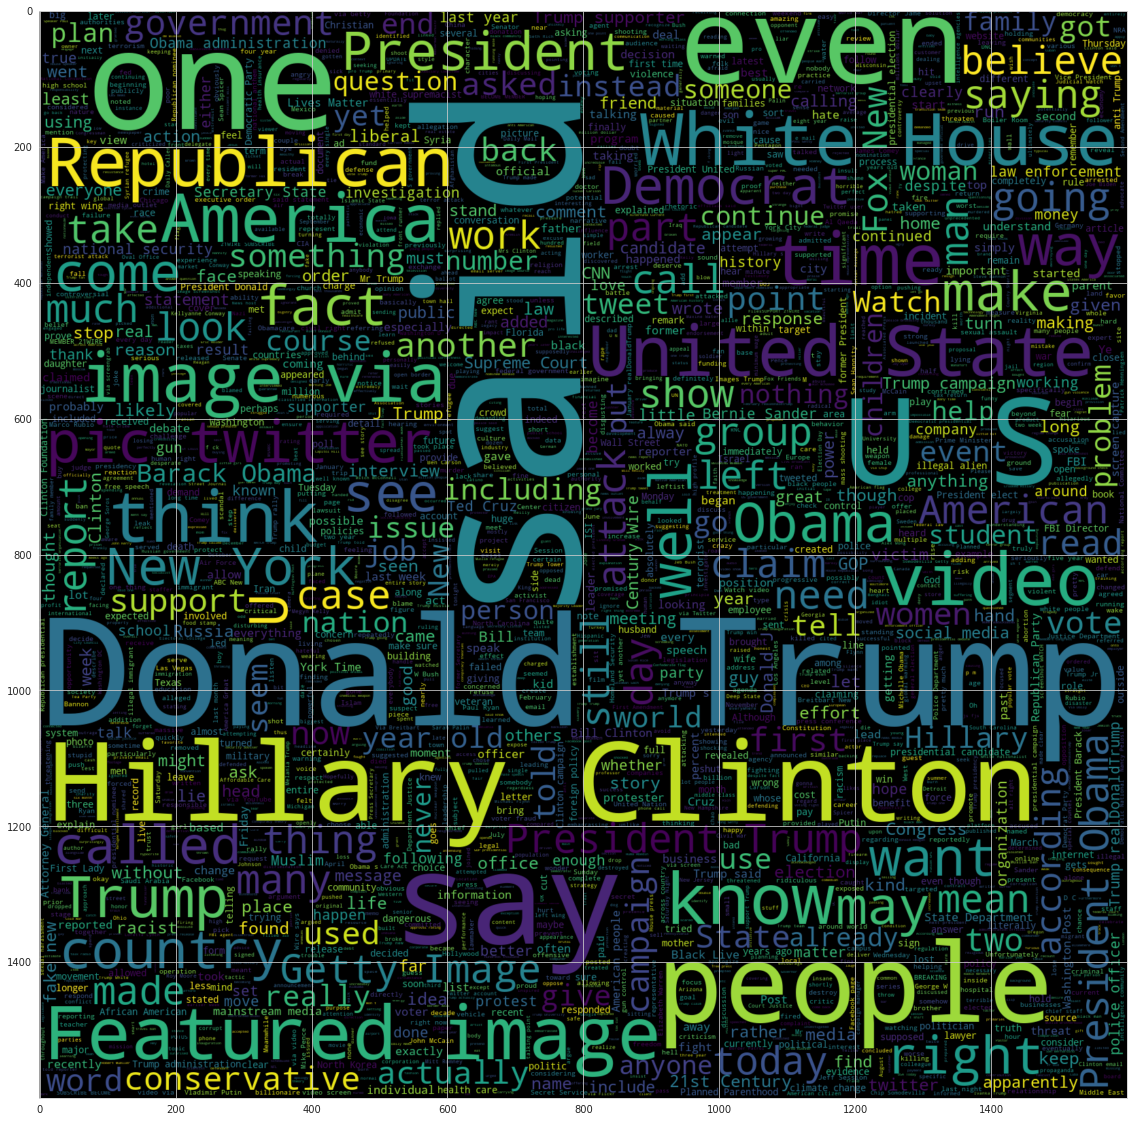

In [20]:
plt.figure(figsize = (20,20)) 
# Text that is Fake
wc = WordCloud(max_words = 2500 , width = 1600 , height = 1600 , stopwords = STOPWORDS).generate(" ".join(df[df.Cat == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

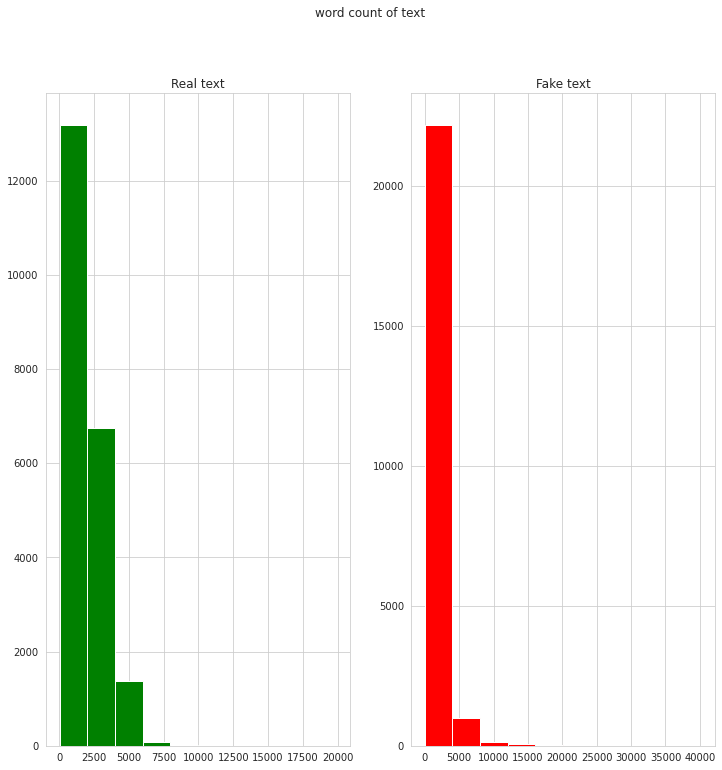

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 12))
text_len = df[df['Cat']==1]['text'].str.len()
ax1.hist(text_len, color='green')
ax1.set_title('Real text')
text_len = df[df['Cat']==0]['text'].str.len()
ax2.hist(text_len, color='red')
ax2.set_title('Fake text')
fig.suptitle('word count of text')
fig.show()

we can see that the count of words in the the news that is fake is higher than in the news that is labelled as real

Now we find the average length of words in a labelled news text

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0.98, 'Average word length in each text')

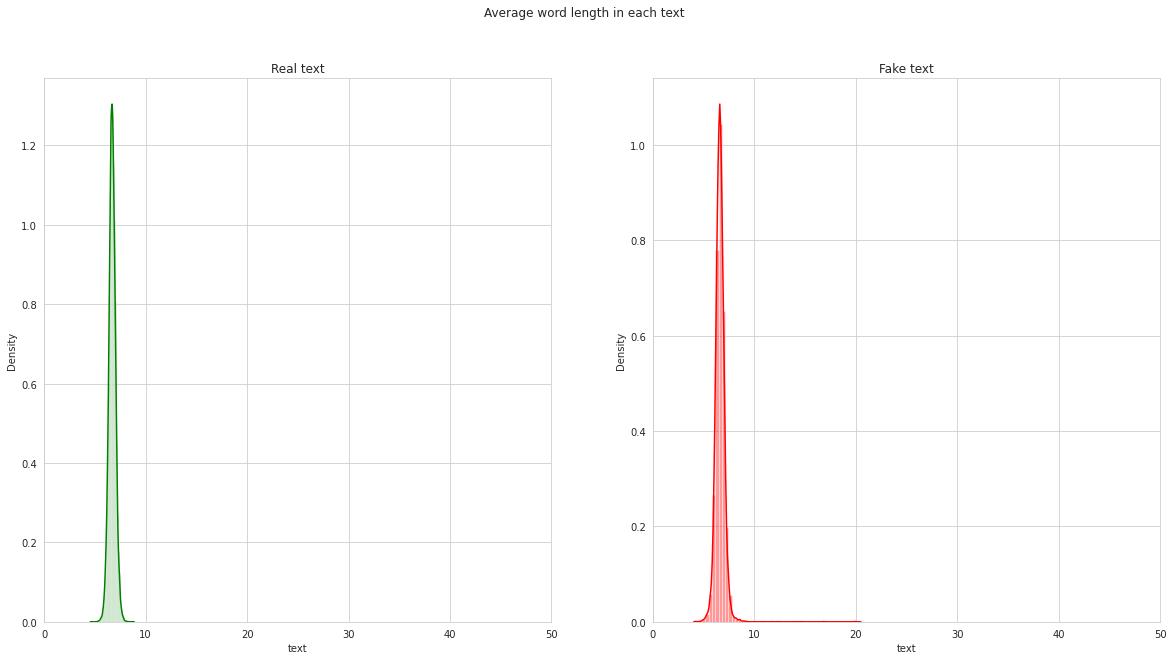

In [22]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word=df[df['Cat']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='green')
ax1.set_xlim(0, 50);
ax1.set_title('Real text')
word=df[df['Cat']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='red')
ax2.set_xlim(0, 50);
ax2.set_title('Fake text')
fig.suptitle('Average word length in each text')

Anomalous text found in fake news as it lasts well beyond 50 letters per words

In [23]:
def get_corpus(text):
  words = []
  for sent in text:
    for word in sent.split():
      words.append(word.strip())
  return words

corpus = get_corpus(df.text)
corpus[:10]

['WASHINGTON',
 '(Reuters)',
 'head',
 'conservative',
 'Republican',
 'faction',
 'U.S.',
 'Congress,',
 'voted',
 'month']

In [24]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(15)
most_common = dict(most_common)
most_common

{'Donald': 27790,
 'House': 23185,
 'Obama': 23176,
 'President': 33171,
 'Republican': 23888,
 'Trump': 111408,
 'U.S.': 50385,
 'also': 30325,
 'could': 23637,
 'one': 29370,
 'people': 33115,
 'said': 93162,
 'said.': 26158,
 'told': 23213,
 'would': 54613}

## Train and test split

In [25]:
x_train, x_test, y_train, y_test = train_test_split(df.text, df.Cat, random_state = 42)

In [26]:
max_features = 10000
maxlen = 300

In [27]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

In [28]:
tokenized_test = tokenizer.texts_to_sequences(x_test)
x_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

## We will now use Global Vector or GloVe to proceed with our analysis

In [29]:
Embed_file = "/content/drive/MyDrive/Datasets/Fake news dataset/glove.twitter.27B.100d.txt"

In [30]:
def get_coeff(word, *array):
  return word, np.asarray(array, dtype= 'float32')
embed_index = dict(get_coeff(*o.rstrip().rsplit(' ')) for o in open(Embed_file))

In [31]:
all_embs = np.stack(embed_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))

#change below line if computing normal stats is too slow
embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embed_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


Model parameters

In [32]:
epochs = 6
embed_size = 100
batch_size = 256

In [33]:
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 2, verbose=1, factor=0.5, min_lr=0.00001)

##Training the model

In [34]:
model = Sequential()

model.add(Embedding(max_features, output_dim = embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))

model.add(LSTM(units=128, return_sequences=True, recurrent_dropout=0.25, dropout=0.25))
model.add(LSTM(units=64, recurrent_dropout=0.1, dropout=0.1))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer= tf.keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          1000000   
                                                                 
 lstm (LSTM)                 (None, 300, 128)          117248    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,168,769
Trainable params: 168,769
Non-trainable params: 1,000,000
_________________________________________________________________


In [36]:
history = model.fit(x_train, y_train, batch_size=batch_size, validation_data=(x_test, y_test), epochs=6, callbacks=[learning_rate_reduction])

Epoch 1/6
132/132 [==============================] - 370s 3s/step - loss: 0.1618 - accuracy: 0.9366 - val_loss: 0.0378 - val_accuracy: 0.9893 - lr: 0.0100
Epoch 2/6
132/132 [==============================] - 357s 3s/step - loss: 0.0335 - accuracy: 0.9890 - val_loss: 0.0144 - val_accuracy: 0.9947 - lr: 0.0100
Epoch 3/6
132/132 [==============================] - 356s 3s/step - loss: 0.0113 - accuracy: 0.9962 - val_loss: 0.0135 - val_accuracy: 0.9953 - lr: 0.0100
Epoch 4/6
132/132 [==============================] - 357s 3s/step - loss: 0.0126 - accuracy: 0.9955 - val_loss: 0.0106 - val_accuracy: 0.9969 - lr: 0.0100
Epoch 5/6
132/132 [==============================] - 353s 3s/step - loss: 0.0110 - accuracy: 0.9963 - val_loss: 0.0117 - val_accuracy: 0.9964 - lr: 0.0100
Epoch 6/6
132/132 [==============================] - 345s 3s/step - loss: 0.0052 - accuracy: 0.9983 - val_loss: 0.0101 - val_accuracy: 0.9980 - lr: 0.0100


In [37]:
#printing the accuracy of the model
print("Accuracy of the model on training data : ", model.evaluate(x_train, y_train)[1]*100, '%')
print("Accuracy of the model on testing data : ", model.evaluate(x_test, y_test)[1]*100, '%')

1053/1053 [==============================] - 162s 154ms/step - loss: 0.0022 - accuracy: 0.9993
Accuracy of the model on training data :  99.92872476577759 %
351/351 [==============================] - 54s 154ms/step - loss: 0.0101 - accuracy: 0.9980
Accuracy of the model on testing data :  99.79510307312012 %


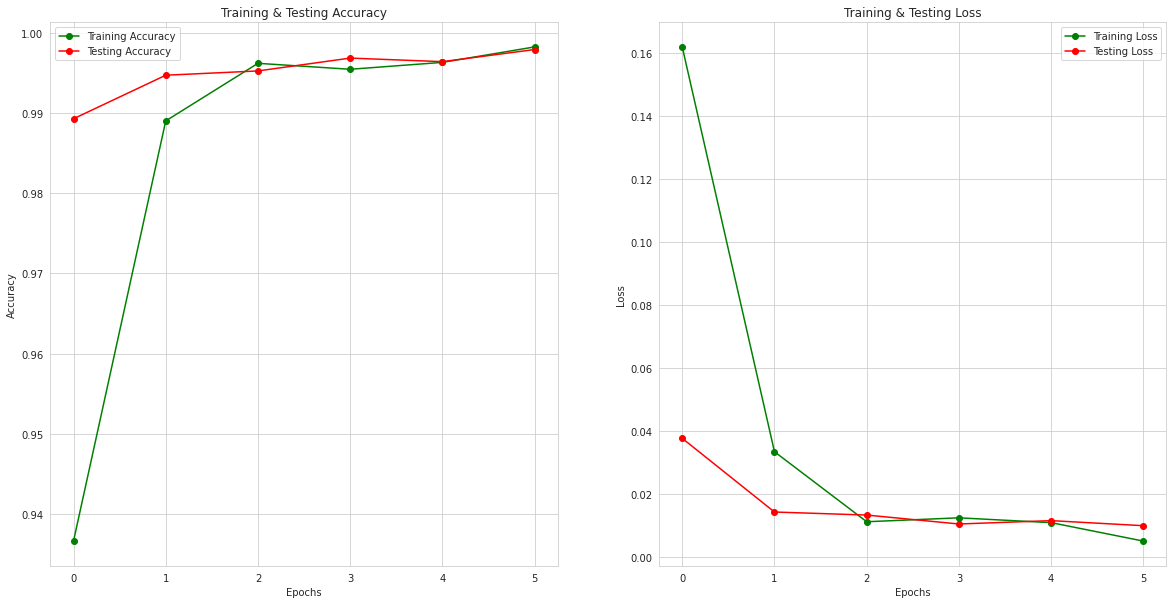

In [38]:
epoch = [i for i in range(6)]
fig, ax = plt.subplots(1, 2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20, 10)

ax[0].plot(epoch , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epoch , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epoch , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epoch , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [39]:
pred = model.predict(x_test)
pred[:10]

array([[2.0488958e-06],
       [6.1216468e-07],
       [9.7890882e-07],
       [9.9995792e-01],
       [2.2052302e-06],
       [9.9998069e-01],
       [9.9995732e-01],
       [9.7639126e-01],
       [9.6603166e-05],
       [1.1021154e-06]], dtype=float32)

In [40]:
np.array(np.unique(y_test, return_counts=True)).T

array([[   0, 5829],
       [   1, 5396]])

In [41]:
np.array(np.unique(pred, return_counts=True)).T

array([[2.33705876e-07, 2.00000000e+00],
       [2.40127633e-07, 1.00000000e+00],
       [2.41574014e-07, 1.00000000e+00],
       ...,
       [9.99987125e-01, 2.00000000e+00],
       [9.99987245e-01, 3.00000000e+00],
       [9.99987483e-01, 1.00000000e+00]])

In [42]:
# pred.shape
round_pred = np.arange(0,11225)
for i in range(11225):
  if pred[i] <0.5:
    round_pred[i] = 0
  else:
    round_pred[i] = 1

In [43]:
print(classification_report(y_test, round_pred, target_names = ['Fake','Not Fake']))
cm = confusion_matrix(y_test, round_pred)
print(cm)

              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      5829
    Not Fake       1.00      1.00      1.00      5396

    accuracy                           1.00     11225
   macro avg       1.00      1.00      1.00     11225
weighted avg       1.00      1.00      1.00     11225

[[5826    3]
 [  20 5376]]


Text(69.0, 0.5, 'Actual')

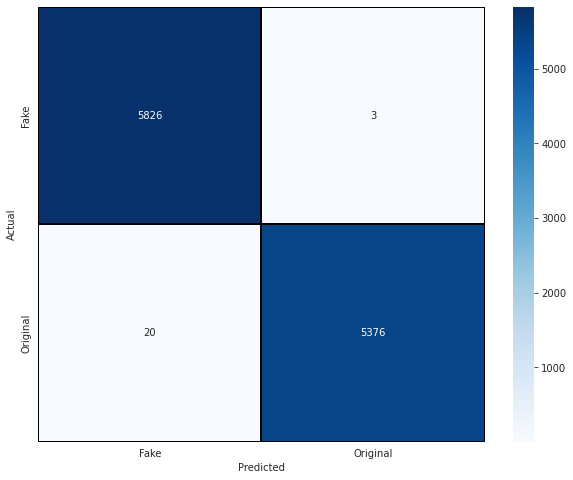

In [44]:
cm = pd.DataFrame(cm, index = ['Fake', 'Real'], columns=['Fake', 'Real'])
plt.figure(figsize = (10,8))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','Original'] , yticklabels = ['Fake','Original'])
plt.xlabel("Predicted")
plt.ylabel("Actual")